In [1]:
!pip install networkx

In [2]:
import root_numpy as rnp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as snb
import json
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
dZ = 205.
BRICK_Z = 75000

def plot3d(shower):
    """
    Function for plotting shower
    """    

    x0, y0, z0 = np.array(shower['TX']), np.array(shower['TY']), np.array(shower['TZ'])
    sx, sy = np.array(shower['SX']), np.array(shower['SY'])

    x1 = x0 + dZ * sx
    y1 = y0 + dZ * sy
    z1 = z0 + dZ
    
    start_points = np.array([x0, y0, z0]).T.reshape(-1, 3)
    end_points = np.array([x1, y1, z1]).T.reshape(-1, 3)

    C = plt.cm.Blues(0.9)
    lc = Line3DCollection(list(zip(start_points, end_points)), colors=C, alpha=0.9, lw=2)

    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-84, elev=0)
    ax.add_collection3d(lc)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z") 
    ax.set_xlim(x0.min(), x1.max())
    ax.set_ylim(y0.min(), y1.max())
    ax.set_zlim(z0.min(), z1.max())

Welcome to JupyROOT 6.16/00


/root/miniconda/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [3]:
# scale factor mm -> \nu m
scale = 10000

# Geometry

In [4]:
import glob

In [5]:
filenames = glob.glob('./data/ship.conical.PG_11-TGeant4.root')

In [6]:
def open_shower_file(filename):
    prefixMC = 'MCTrack'
    prefixTargetPoint = 'TargetPoint'
    showers_data_root = rnp.root2array(filename, treename='cbmsim', branches=[prefixMC+'.fPx', 
                                                                              prefixMC+'.fPy', 
                                                                              prefixMC+'.fPz', 
                                                                              prefixMC+'.fStartX', 
                                                                              prefixMC+'.fStartY', 
                                                                              prefixMC+'.fStartZ',
                                                                              prefixMC+'.fMotherId',
                                                                              prefixMC+'.fPdgCode',
                                                                              prefixMC+'.fM',
                                                                              prefixMC+'.fW',
                                                                              prefixTargetPoint+'.fPx', 
                                                                              prefixTargetPoint+'.fPy', 
                                                                              prefixTargetPoint+'.fPz', 
                                                                              prefixTargetPoint+'.fX', 
                                                                              prefixTargetPoint+'.fY', 
                                                                              prefixTargetPoint+'.fZ',
                                                                              prefixTargetPoint+'.fTime',
                                                                              prefixTargetPoint+'.fLength',
                                                                              prefixTargetPoint+'.fELoss',
                                                                              prefixTargetPoint+'.fDetectorID',
                                                                              prefixTargetPoint+'.fTrackID',
                                                                              prefixTargetPoint+'.fLink'])
    return showers_data_root

In [7]:
%%time
showers_data_root = open_shower_file(filename=filenames[0])

CPU times: user 1min 6s, sys: 168 ms, total: 1min 6s
Wall time: 1min 6s


Warning in <TClass::Init>: no dictionary for class ShipMCTrack is available
Warning in <TClass::Init>: no dictionary for class ShipRpcPoint is available
Warning in <TClass::Init>: no dictionary for class FairMCPoint is available
Warning in <TClass::Init>: no dictionary for class FairMultiLinkedData_Interface is available
Warning in <TClass::Init>: no dictionary for class FairMultiLinkedData is available
Warning in <TClass::Init>: no dictionary for class FairLink is available
Warning in <TClass::Init>: no dictionary for class TargetPoint is available
Warning in <TClass::Init>: no dictionary for class TTPoint is available
Warning in <TClass::Init>: no dictionary for class HptPoint is available
Warning in <TClass::Init>: no dictionary for class FairMCEventHeader is available
Warning in <TClass::Init>: no dictionary for class FairFileHeader is available


In [10]:
import networkx as nx

In [11]:
def gen_nodes_for_edge(N, indices, fPx_sim, fPy_sim, fPz_sim, fStartX_sim, fStartY_sim, fStartZ_sim):
    nodes = []
    for i, idx in enumerate(indices):
        nodes.append(
            (
                i + N,
                {
                    'SX': fPx_sim[idx]/fPz_sim[idx],
                    'SY': fPy_sim[idx]/fPz_sim[idx],
                    'TX': fStartX_sim[idx],
                    'TY': fStartY_sim[idx],
                    'TZ': fStartZ_sim[idx]
                }
            )
        )
    nodes = sorted(nodes, key=lambda x: x[1]['TZ'])
    return nodes

def create_particle_graph(fMotherId_mc, fTrackID_sim, mask_sim, 
                          fPx_sim, fPy_sim, fPz_sim, 
                          fStartX_sim, fStartY_sim, fStartZ_sim):
    G = nx.DiGraph()
    G.add_nodes_from(list(range(len(fMotherId_mc))))

    ids = np.arange(len(fMotherId_mc))
    for node in ids[1:]:
        G.add_edge(fMotherId_mc[node], node)
    
    nodes_not_in_graph = list(set(ids) - set(np.unique(fTrackID_sim[np.isin(fTrackID_sim, ids)])))
    for node in nodes_not_in_graph:
        G.add_edges_from(list(product(list(G.predecessors(node)), list(G.successors(node)))))
        G.remove_node(node)
        
    N = 0
    for node in G:
        mask_local = mask_sim & (fTrackID_sim == node)
        G.node[node]['nodes'] = gen_nodes_for_edge(N, np.where(mask_local)[0], 
                                                   fPx_sim, fPy_sim, fPz_sim, 
                                                   fStartX_sim, fStartY_sim, fStartZ_sim)
        N += len(G.node[node]['nodes'])
        
    return G

In [12]:
def modify_graph_with_tracks(G, g, graph_node, last_track_node, first_run=False):
    if not first_run:
        g.add_nodes_from(G.node[graph_node]['nodes'])
        g.add_edge(last_track_node, G.node[graph_node]['nodes'][0][0])
        g.add_path([n[0] for n in G.node[graph_node]['nodes']])
    last_track_node = G.node[graph_node]['nodes'][-1][0]
    for new_graph_node in G.successors(graph_node):
        modify_graph_with_tracks(G=G, g=g, 
                                 graph_node=new_graph_node, 
                                 last_track_node=last_track_node)
        
def create_track_graph(G):
    graph_node = list(G.nodes())[0]

    g = nx.DiGraph()
    g.add_nodes_from(G.node[graph_node]['nodes'])

    g.add_path([n[0] for n in G.node[graph_node]['nodes']])

    last_track_node = G.node[graph_node]['nodes'][-1][0]
    
    modify_graph_with_tracks(G=G, g=g, last_track_node=last_track_node, 
                             graph_node=graph_node, first_run=True)
    
    return g

In [13]:
fPx_mc, fPy_mc, fPz_mc, fStartX_mc, \
        fStartY_mc, fStartZ_mc, fMotherId_mc, fPdgCode_mc, \
        fM_mc, fW_mc, fPx_sim, fPy_sim, fPz_sim, fStartX_sim, \
        fStartY_sim, fStartZ_sim, fTime_sim, fLength_sim, \
        fELoss_sim, fDetectorID_sim, fTrackID_sim, fLink_sim = showers_data_root[6]


mask_sim = np.full_like(fPx_sim, fill_value=True, dtype=np.bool)

mask_sim = mask_sim & (np.abs(fPx_sim / fPz_sim) <= 1.) & (np.abs(fPy_sim / fPz_sim) <= 1.)
fTrackID_sim[~mask_sim] = -2
mask_sim = mask_sim & (np.isin(fTrackID_sim, np.arange(len(fMotherId_mc))))

In [14]:
%%time
from itertools import product
G = create_particle_graph(fMotherId_mc, fTrackID_sim, mask_sim, 
                          fPx_sim, fPy_sim, fPz_sim, 
                          fStartX_sim, fStartY_sim, fStartZ_sim)

g = create_track_graph(G)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.97 ms


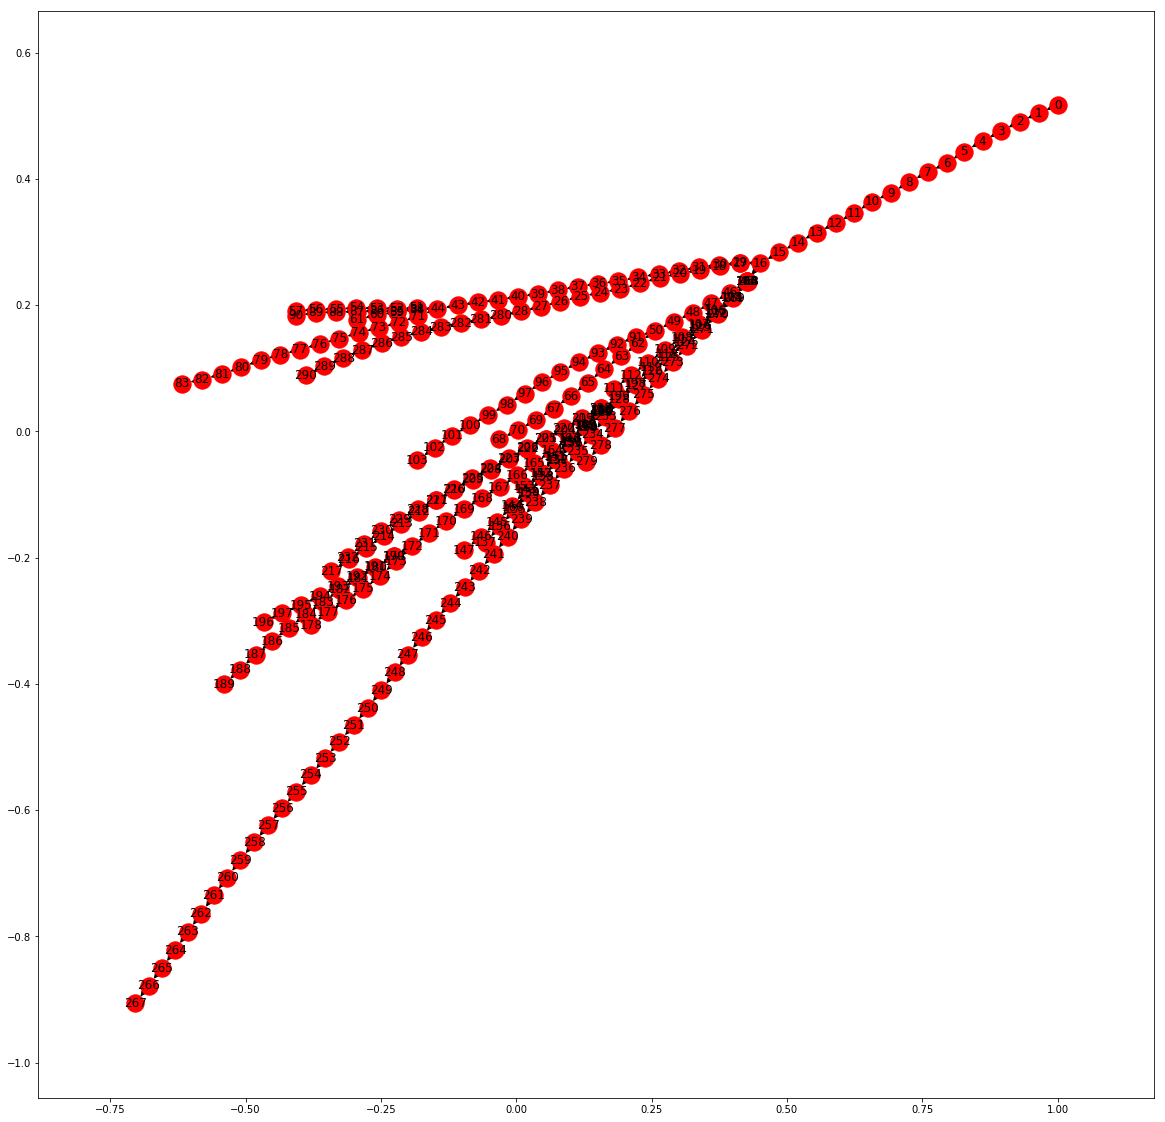

In [15]:
plt.figure(figsize=(20, 20))
pos = nx.drawing.layout.kamada_kawai_layout(g)
nx.draw_networkx(g, pos)
plt.show()

In [16]:
from collections import namedtuple
def graph_to_df(g):
    df = pd.DataFrame([g.nodes[i] for i in g])
    # df.loc[:,'TX'] *= scale
    # df.loc[:,'TY'] *= scale
    # df.loc[:,'TZ'] *= scale
    return df


shower_adj = namedtuple('shower_adj', field_names=['x', 'adj', 'ele_p'])

In [17]:
from tqdm import tqdm_notebook as tqdm
z_start = -3256.67
z_end = -3234.4465
from collections import namedtuple


def extract_showers(showers_data_root, LIM=100):
    showers = []
    
    for shower_data_root in tqdm(showers_data_root):
        # extract data
        fPx_mc, fPy_mc, fPz_mc, fStartX_mc, \
        fStartY_mc, fStartZ_mc, fMotherId_mc, _, \
        fM_mc, fW_mc, fPx_sim, fPy_sim, fPz_sim, fStartX_sim, \
        fStartY_sim, fStartZ_sim, fTime_sim, fLength_sim, \
        fELoss_sim, fDetectorID_sim, fTrackID_sim, fLink_sim = shower_data_root

        
        # scale mc data 
        fStartX_mc = scale * fStartX_mc; fStartY_mc = scale * fStartY_mc; fStartZ_mc = scale * fStartZ_mc
        # scale simulation data
        fStartX_sim = scale * fStartX_sim; fStartY_sim = scale * fStartY_sim; fStartZ_sim = scale * fStartZ_sim
        
        # create mask filled with True values
        mask_sim = np.full_like(fPx_sim, fill_value=True, dtype=np.bool)

        # get rid of tracks with tg(alpha) > 1
        # because they are moving in wrong direction
        mask_sim = mask_sim & (np.abs(fPx_sim / fPz_sim) <= 1.) & (np.abs(fPy_sim / fPz_sim) <= 2.)
        fTrackID_sim[~mask_sim] = -2

        # 0-length tracks looks bad
        # mask_sim = mask_sim & (fLength_sim != 0)

        # select tracks that only associated with MC EM-shower 
        mask_sim = mask_sim & (np.isin(fTrackID_sim, np.arange(len(fMotherId_mc))))

        if sum(mask_sim) < LIM:
            continue

        # filtration by min Z; minZ = Z of mother particle
        # minZ_sim = -3253.0 * scale
        # minZ_sim = np.percentile(fStartZ_sim, q=1)
        minZ_sim = fStartZ_mc[0]
        mask_sim = mask_sim & (fStartZ_sim >= z_start * scale)

        # min Z + one brick
        maxZ_sim = minZ_sim + BRICK_Z
        mask_sim = mask_sim & (fStartZ_sim <= z_end * scale) 

        # centers of X, Y showers are X, Y of mother particle
        centerX_sim = fStartX_mc[0]
        centerY_sim = fStartY_mc[0]

        if sum(mask_sim) < LIM:
            continue
        
        
        G = create_particle_graph(fMotherId_mc, fTrackID_sim, mask_sim, 
                                  fPx_sim, fPy_sim, fPz_sim, 
                                  fStartX_sim, fStartY_sim, fStartZ_sim - z_start * scale)

        g = create_track_graph(G)
        
        shower = shower_adj(x=graph_to_df(g),
                            adj=nx.adjacency_matrix(g).toarray(),
                            ele_p=np.sqrt(fPx_mc[0]**2 + fPy_mc[0]**2 + fPz_mc[0]**2))
        showers.append(shower)
        """
        shower_sim = {
            'SX': list((fPx_sim/fPz_sim)[mask_sim]), # tg(alpha)
            'SY': list((fPy_sim/fPz_sim)[mask_sim]), # tg(alpha)
            'TX': list(fStartX_sim[mask_sim] - centerX_sim),
            'TY': list(fStartY_sim[mask_sim] - centerY_sim),
            'TZ': list(fStartZ_sim[mask_sim] - minZ_sim),
            'MotherPX': fPx_mc[0],
            'MotherPY': fPy_mc[0],
            'MotherPZ': fPz_mc[0],
            'MotherPM': fM_mc[0],
            'MotherPTX': fStartX_sim[0],
            'MotherPTY': fStartY_sim[0],
            'MotherPTZ': fStartZ_sim[0],
            'EnergyLossPerTrack': fELoss_sim[mask_sim],
            'AssociatedParticle': fTrackID_sim[mask_sim],
            'ParticleChain': fMotherId_mc
        }    

        shower_mc = {
            'SX': list((fPx_mc/fPz_mc)[mask_mc]), # tg(alpha)
            'SY': list((fPy_mc/fPz_mc)[mask_mc]), # tg(alpha)
            'TX': list(fStartX_mc[mask_mc] - centerX_sim),
            'TY': list(fStartY_mc[mask_mc] - centerY_sim),
            'TZ': list(fStartZ_mc[mask_mc] - minZ_sim),
        }
        """

        
    return showers

In [18]:
showers = extract_showers(showers_data_root)

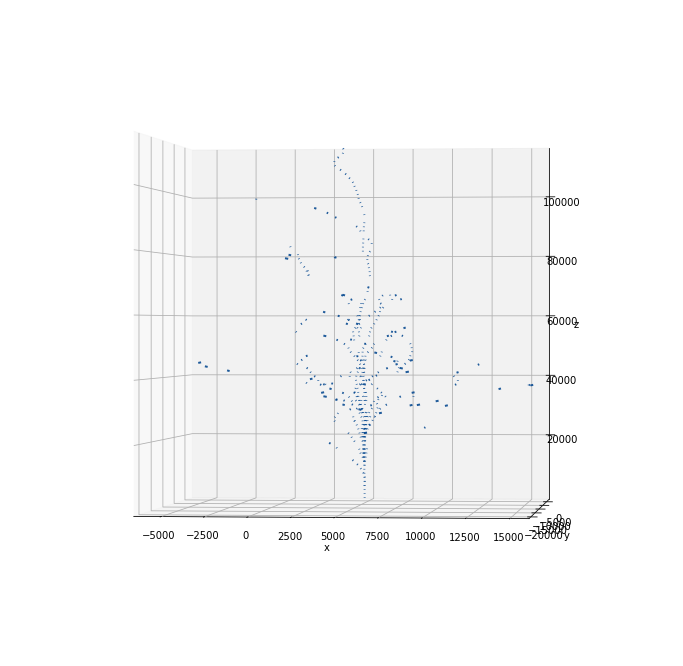

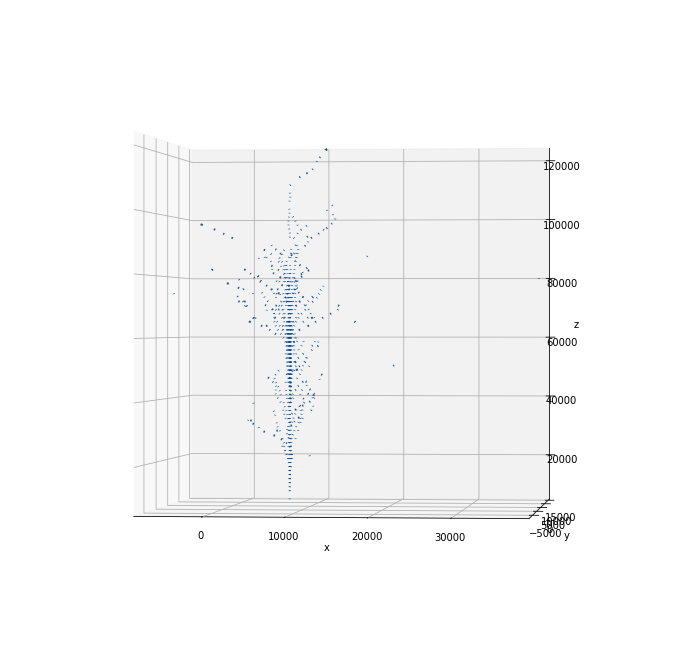

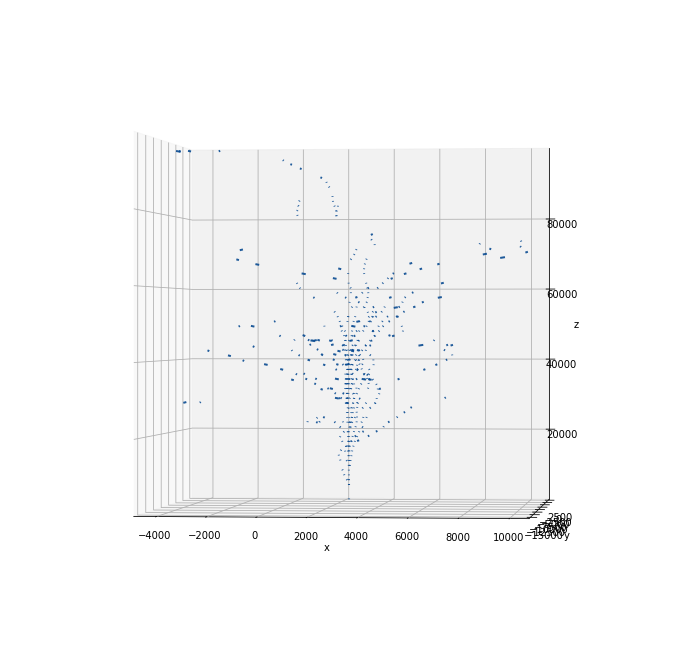

In [21]:
for shower in showers[:3]:
    plot3d(shower.x)

In [22]:
import pickle
pickle.dump(showers, open("./data/showers_ship.pkl", "wb"))

In [23]:
showers[0].x.shape

(416, 5)